In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

%matplotlib inline

sns.set_context('paper')
data_dir = Path('../data')
input_dir = data_dir / 'input'
output_dir = data_dir / 'output'
figure_dir = Path("../figures")

df = pd.read_csv(output_dir / '04_language_detection.csv',
                 parse_dates=['created', 'deposited'],
                 index_col='Index')

### Completeness and Quality issues

Dividing issues between 'Completeness' and 'Quality' and getting the sum of issues for each record

In [2]:
completeness = ['no_author', 'no_language', 'no_title', 
                'no_abstract', 'author_characters', 'affiliation_missing']
quality = ['author_sequence', 'author_institutions',
           'abstract_multi_lang', 'title_language', 
           'author_uppercase','author_honorific']
df['completeness_errors'] = df[completeness].sum(axis=1)
df['quality_errors'] = df[quality].sum(axis=1)

### Categorization

Initially, we simply labeled records according to these groupings, here we are doing to change their `dtype` to a categorical one. Applying to both Publisher Size as well as Language Type.

In [3]:
cat_size_order = pd.api.types.CategoricalDtype(
    ['XS', 'S', 'M', 'L', 'XL'], 
    ordered=True
)

cat_lang_order = pd.api.types.CategoricalDtype(
    ['Multilingual', 'Monolingual (excl. en)', 'English'],
    ordered=True
)
df['publisher_bin'] = df['publisher_bin'].astype(cat_size_order)
df['lang_type'] = df['lang_type'].astype(cat_lang_order)
pivot = pd.pivot_table(df, values='quality_errors', index='publisher_bin',
                       columns=['lang_type'], aggfunc=np.mean)

/tmp/ipykernel_34418/1136034956.py:12: FutureWarning: The provided callable <function mean at 0x7f545c17f640> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot = pd.pivot_table(df, values='quality_errors', index='publisher_bin',


### Renaming

Renaming the columns relevant to the visualizations for cleaner appearance in viz.

In [4]:
palette = ['coral', 'thistle', 'skyblue']
sns.set_context('paper')
df2 = df.rename({'publisher_bin':'Publisher Size', 'lang_type': 'Language Type',
                 'no_author': 'Authors', 'no_language': 'Language',
                 'no_abstract' : 'Abstract', 'no_title' : 'Title',
                 'author_characters': 'Language Style', 'author_institutions': 'Affiliation as Author',
                 'author_sequence': 'Author Sequence', 'title_language': 'Language Does Not Match',
                 'author_initials': 'Only Initials Provided',
                 'abstract_multi_lang' : 'Multilingual Abstract',
                 'author_honorific': 'Honorific in Name',
                 'author_uppercase':'Author Name in All Caps',
                 'affiliation_missing':'Affiliation'}, axis=1)

### Completeness Issues

Viz for showing completeness issues, Grouped bar chart for seeing differences between language types.

/tmp/ipykernel_28876/810756817.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df.Affiliation.fillna(0, inplace=True)
/tmp/ipykernel_28876/810756817.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = comp_df.groupby('Language Type')[issue_columns].mean(numeric_only=True).reset_index()


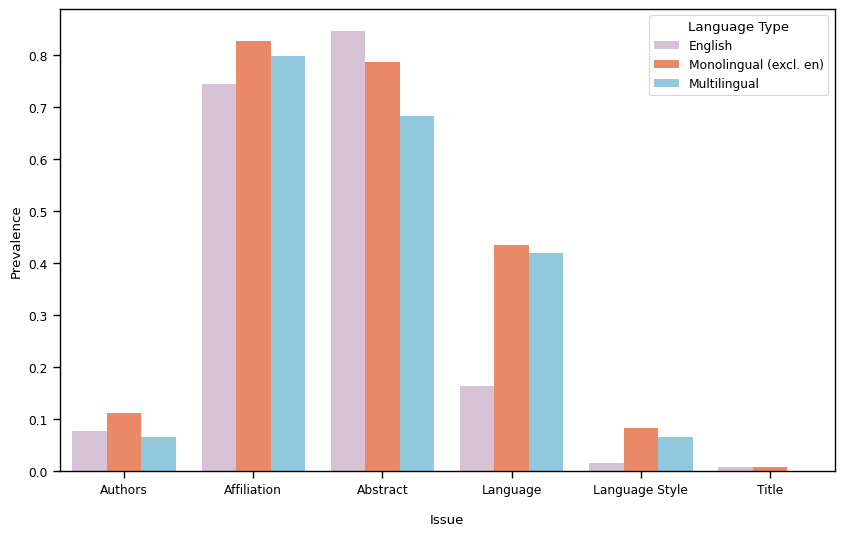

In [5]:
comp_df = df2[['Language Type', 'Authors', 'Affiliation', 'Abstract', 'Language', 'Language Style','Title']]
issue_columns = ['Language Type', 'Authors', 'Affiliation', 'Abstract', 'Language', 'Language Style','Title']
comp_df.Affiliation.fillna(0, inplace=True)
grouped = comp_df.groupby('Language Type')[issue_columns].mean(numeric_only=True).reset_index()
melted = grouped.melt(id_vars='Language Type', var_name='issue', value_name='prevalence')

plt.figure(figsize=(10, 6))
sns.barplot(x='issue', y='prevalence', hue='Language Type', data=melted, palette=['thistle','coral', 'skyblue'],
            hue_order=['English', 'Monolingual (excl. en)', 'Multilingual'])
#plt.title('Prevalence of Issues Across Language Types')
plt.xlabel('Issue', labelpad=12.5)
plt.ylabel('Prevalence')
#plt.xticks(rotation=20)
plt.savefig(figure_dir / 'comp_lang_type.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

### Quality

A viz similar to above, but pertaining to the quality issues.

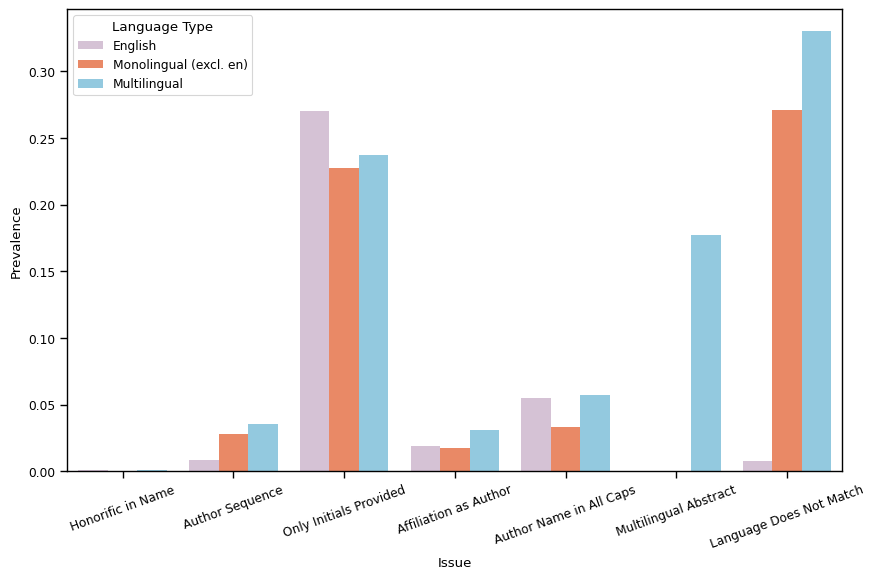

In [6]:
qual_df = df2[['Language Type', 'Author Sequence', 'Only Initials Provided', 'Affiliation as Author',
              'Multilingual Abstract', 'Language Does Not Match',
              'Honorific in Name', 'Author Name in All Caps']]

issue_columns = ['Language Type', 'Honorific in Name', 'Author Sequence', 
                 'Only Initials Provided', 'Affiliation as Author', 'Author Name in All Caps',
                 'Multilingual Abstract', 'Language Does Not Match']
grouped = qual_df.groupby('Language Type', observed=False)[issue_columns].mean(numeric_only=True).reset_index()
melted = grouped.melt(id_vars='Language Type', var_name='issue', value_name='prevalence')

plt.figure(figsize=(10, 6))
sns.barplot(x='issue', y='prevalence', hue='Language Type', data=melted, palette=['thistle','coral', 'skyblue'],
            hue_order=['English', 'Monolingual (excl. en)', 'Multilingual'])
#plt.title('Prevalence of Issues Across Language Types')
plt.xlabel('Issue')
plt.ylabel('Prevalence')
plt.xticks(rotation=20)
plt.savefig(figure_dir / 'quality_lang_type.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

### Language Type x Publisher Size

Chart showing the representation of language types across publisher size groups.

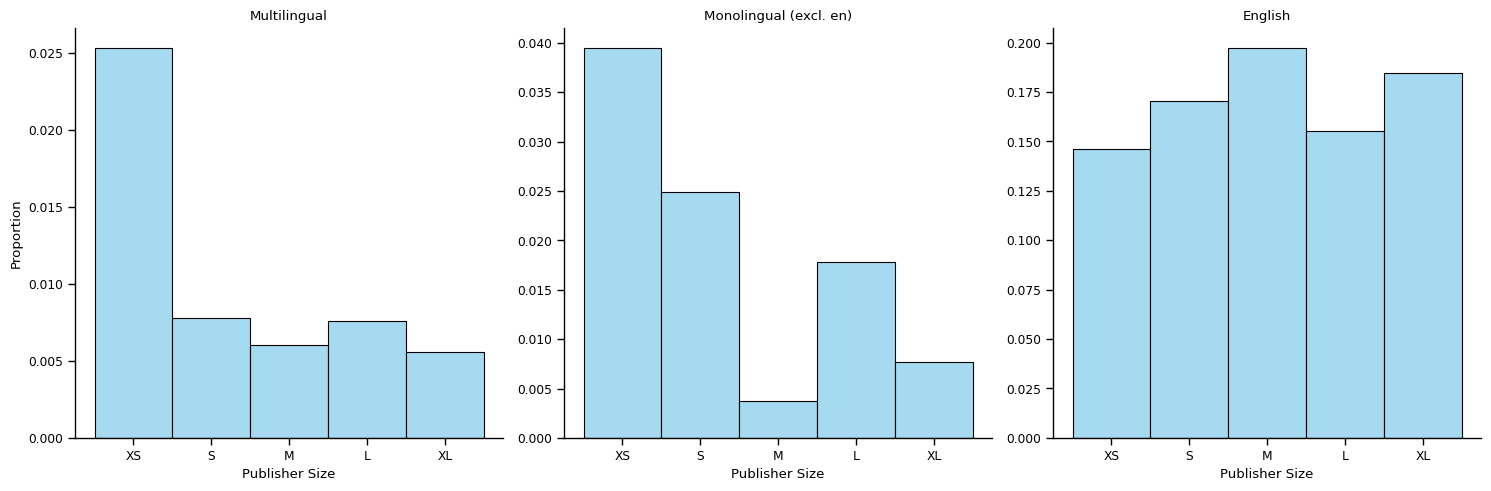

In [8]:
d = sns.displot(df2, x='Publisher Size', stat='proportion', col='Language Type',
                color='skyblue', facet_kws={'sharey':False})
d.set_titles('{col_name}')
plt.savefig(figure_dir / 'pubsize_x_langtype.png', format='png', bbox_inches='tight',
            dpi=600)
plt.show()

### Heatmaps - Issues: Pub Size x Lang Type

First Quality issue, then completeness.

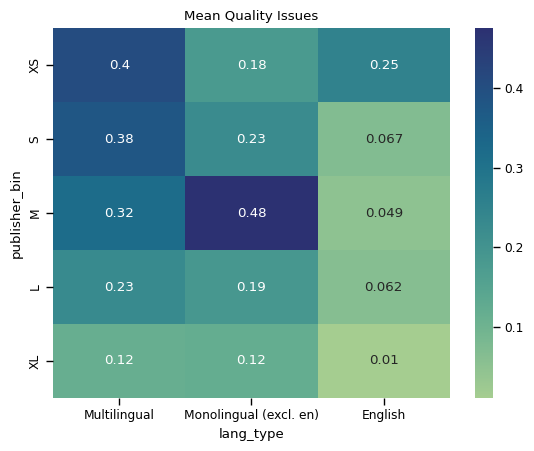

In [4]:
fng = sns.heatmap(pivot, annot=True, cmap ='crest').set(title='Mean Quality Issues')
plt.savefig(figure_dir / 'size_lang_heatmap.png', format='png', dpi=600)
plt.show()

/tmp/ipykernel_31546/4073851023.py:1: FutureWarning: The provided callable <function mean at 0x7f9ea01a7640> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot = pd.pivot_table(df2, values='completeness_errors', index='Publisher Size',


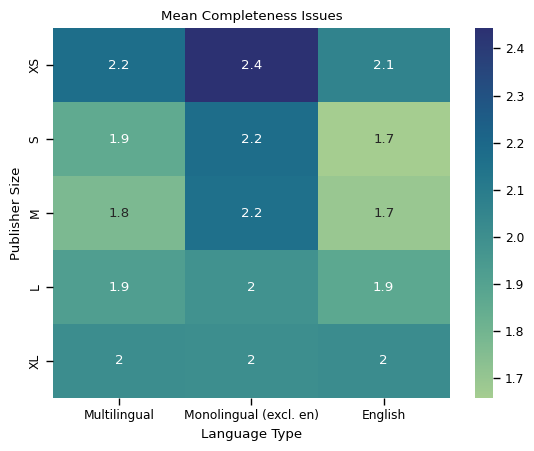

In [8]:
pivot = pd.pivot_table(df2, values='completeness_errors', index='Publisher Size',
                       columns=['Language Type'], aggfunc=np.mean)
fng = sns.heatmap(pivot, annot=True, cmap ='crest').set(title='Mean Completeness Issues')
plt.savefig(figure_dir / 'size_lang_complete_heat.png', format='png', dpi=600)
plt.show()

## Summary statistics

In [20]:
pub_groups = ['XS', 'S', 'M', 'L', 'XL']

for i in pub_groups:
    temp = df.loc[df.publisher_bin == i]
    num_journ = str(temp['container-title'].nunique())
    num_pub = str(temp.publisher.nunique())
    smaller = temp[['publisher', 'DOI']]
    med_rec = smaller.groupby('publisher').count()
    med_rec = str(med_rec.median())
    print(f'{i} -- Journals: {num_journ}, Publishers: {num_pub}, Median Records: {med_rec}\n')


XS -- Journals: 11400, Publishers: 5550, Median Records: DOI    1.0
dtype: float64

S -- Journals: 4596, Publishers: 77, Median Records: DOI    183.0
dtype: float64

M -- Journals: 4745, Publishers: 9, Median Records: DOI    1736.0
dtype: float64

L -- Journals: 4212, Publishers: 2, Median Records: DOI    9184.0
dtype: float64

XL -- Journals: 2562, Publishers: 1, Median Records: DOI    19632.0
dtype: float64



In [16]:
lang_groups = ['English', 'Monolingual (excl. en)', 'Multilingual']

for i in lang_groups:
    temp = df.loc[df.lang_type == i]
    num_rec = str(temp.shape[0])
    num_pub = str(temp.publisher.nunique())
    rec_pub = str(temp.shape[0]/temp.publisher.nunique())
    num_journ = str(temp['container-title'].nunique())
    print(f'{i} -- \n')
    print(f'Records: {num_rec}, Publishers: {num_pub}, Mean: {rec_pub}, Journals: {num_journ}\n')

English -- 

Records: 82326, Publishers: 3821, Mean: 21.54566867312222, Journals: 20423

Monolingual (excl. en) -- 

Records: 9044, Publishers: 1583, Mean: 5.7132027795325335, Journals: 4922

Multilingual -- 

Records: 5053, Publishers: 1310, Mean: 3.8572519083969468, Journals: 2934



In [18]:
temp = df.loc[df.lang_type.isna()]
num_rec = temp.shape[0]
num_pub = temp.publisher.nunique()
rec_pub = temp.shape[0]/temp.publisher.nunique()
num_journ = temp['container-title'].nunique()
print(f'Uncategorized -- \n')
print(f'Records: {num_rec}, Publishers: {num_pub}, Mean: {rec_pub}, Journals: {num_journ}\n')

Uncategorized -- 

Records: 3577, Publishers: 322, Mean: 11.108695652173912, Journals: 1767



### Completeness issues

In [8]:
issues = ['Authors', 'Affiliation', 'Abstract', 'Language', 'Language Style','Title']
comp = df2.loc[(df2['Authors'] == 1) | (df2['Affiliation'] == 1) |
              (df2['Abstract'] == 1) | (df2['Language'] == 1) |
              (df2['Language Style'] == 1) | (df2['Title'] == 1)]
prev_comp = (comp.shape[0]/df2.shape[0]) * 100
print(f'Prevalence of Completeness Issues: {prev_comp}\n')

for i in issues:
    temp = df2.loc[df2[i] == 1]
    prev = (temp.shape[0]/df2.shape[0]) * 100
    print(f'Prevalence of {i} Completeness Issues: {prev}\n')

Prevalence of Completeness Issues: 94.651

Prevalence of Authors Completeness Issues: 9.041

Prevalence of Affiliation Completeness Issues: 74.776

Prevalence of Abstract Completeness Issues: 83.745

Prevalence of Language Completeness Issues: 20.11

Prevalence of Language Style Completeness Issues: 2.024

Prevalence of Title Completeness Issues: 1.036



### Quality Issues

The first set is the prevalence within the entire sample, (# of Records with Issue)/(# of Records in the sample).

The second set looks at each issue as (# of Records with issue)/(# of Records with data within the Field) e.g. (# of Multilingual Abstracts)/(# of Records that have abstracts)

In [9]:
issues = ['Honorific in Name', 'Author Sequence', 
               'Affiliation as Author', 'Author Name in All Caps',
               'Multilingual Abstract', 'Language Does Not Match',
               'Only Initials Provided']

#Status and Language categories. "Value disagrees with parameters of field" Form. Excludes initials in author name
status_lang = df2.loc[(df2['Honorific in Name'] == 1) | (df2['Author Sequence'] == 1) |
               (df2['Affiliation as Author'] == 1) | (df2['Author Name in All Caps'] == 1) |
               (df2['Multilingual Abstract'] == 1) | (df2['Language Does Not Match'] == 1)]
prev_status = (status_lang.shape[0]/df2.shape[0]) * 100
print(f'Prevalence of Status and Language Issues: {prev_status}\n')

for i in issues:
    temp = df2.loc[df2[i] == 1]
    prev = (temp.shape[0]/df2.shape[0]) * 100
    print(f'Prevalence of {i} Quality Issues: {prev}\n')

Prevalence of Status and Language Issues: 9.939

Prevalence of Honorific in Name Quality Issues: 0.08800000000000001

Prevalence of Author Sequence Quality Issues: 1.0710000000000002

Prevalence of Affiliation as Author Quality Issues: 1.764

Prevalence of Author Name in All Caps Quality Issues: 4.7219999999999995

Prevalence of Multilingual Abstract Quality Issues: 0.28300000000000003

Prevalence of Language Does Not Match Quality Issues: 2.4899999999999998

Prevalence of Only Initials Provided Quality Issues: 24.111



In [14]:
issue_dict = {'Multilingual Abstract': 'abstract',
              'Honorific in Name': 'author',
              'Author Sequence': 'author',
              'Affiliation as Author' : 'author',
              'Author Name in All Caps': 'author',
              'Language Does Not Match': 'language',
              'Only Initials Provided' : 'author'}

for k,v in issue_dict.items():
    temp = df2.loc[df2[k] == 1]
    other = df.loc[df[v].notnull()]
    prev = (temp.shape[0]/other.shape[0]) * 100
    print(f'Prevalence of {k} Quality Issues: {prev}\n')


Prevalence of Multilingual Abstract Quality Issues: 1.7410027683789604

Prevalence of Honorific in Name Quality Issues: 0.09674688595960818

Prevalence of Author Sequence Quality Issues: 1.1774535779856858

Prevalence of Affiliation as Author Quality Issues: 1.9393353049176003

Prevalence of Author Name in All Caps Quality Issues: 5.191349948878066

Prevalence of Language Does Not Match Quality Issues: 3.1167855801727375

Prevalence of Only Initials Provided Quality Issues: 26.50754735650128

